In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from datetime import datetime
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float
import random
import math
import pandas as pd
from matplotlib import rc
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from pykalman import KalmanFilter
import nolds
from statsmodels.tsa.stattools import adfuller
from scipy.signal import find_peaks
from scipy.stats import entropy as scipy_entropy
from pyproj import Transformer



## machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# Add MiKTeX bin directory to PATH
os.environ['PATH'] += os.pathsep + r'C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64'

# Verify the update
print("Updated PATH:")
print(os.environ['PATH'])

# Print LaTeX configuration
print("LaTeX configuration:")
print(os.popen("latex --version").read())


Updated PATH:
c:\Users\olive\AppData\Local\Programs\Python\Python311;c:\Users\olive\AppData\Roaming\Python\Python311\Scripts;C:\Program Files\Common Files\Oracle\Java\javapath;C:\Program Files (x86)\Common Files\Oracle\Java\java8path;C:\Program Files (x86)\Common Files\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Git\cmd;C:\Program Files\dotnet\;C:\Program Files\Pandoc\;C:\Users\olive\AppData\Local\Programs\Python\Python311;C:\Users\olive\AppData\Local\Programs\Python\Python311\Scripts;C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64;C:\Users\olive\AppData\Local\Programs\Python\Python311\Scripts;C:\Users\olive\AppData\Local\Programs\Python\Python311;C:\Users\olive\AppData\Local\Microsoft\WindowsApps;C:\Users\olive\AppData\Local\Programs\Microsoft VS Code\bin;C:\Program Files\esa-snap\bin;C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64\;C:\Prog

In [3]:
# Set specific font sizes
plt.rcParams.update({
    'font.size': 20,          # Global font size
    'axes.titlesize': 11,     # Title font size
    'axes.labelsize': 20,     # X and Y axis labels font size
    'xtick.labelsize': 14,    # X-axis tick labels font size
    'ytick.labelsize': 14,    # Y-axis tick labels font size
    'legend.fontsize': 14,    # Legend font size
})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [4]:
df=pd.read_csv('saved_attribute_table.csv')
attribute_table2=pd.read_csv('attribute_table_2.csv')

In [5]:
df

,fid,event,last_alive,first_stan,last_stand,first_gap,notes,confirmed,centroid_x,centroid_y,area
0,22,standing&b/u,NaN,2016-06,2017-12,2018-06,NaN,checked,556651.360,9533727.893,105.412
1,23,standing&b/u,NaN,2016-06,2017-06,2017-12,NaN,checked,555897.816,9533599.821,156.257
2,46,standing&b/u,2016-06,2016-12,2023-04,2023-10,very few branches and mostly gap now,checked,561176.381,9523245.382,106.495
3,62,standing&b/u,2018-06,2018-12,2019-06,2020-06,NaN,checked,563785.032,9527067.637,207.746
4,66,b/u,2023-09,NaN,NaN,2023-10,NaN,checked,563329.777,9527728.359,265.294
...,...,...,...,...,...,...,...,...,...,...,...
102,936,?b/u,2022-10,NaN,NaN,2022-11,NaN,?,557663.011,9544779.686,41.274
103,938,b/u,2022-10,NaN,NaN,2022-11,NaN,checked,557568.600,9544912.789,122.074
104,954,standing&b/u,2019-06,2019-12,2020-06,2020-11,NaN,checked,558675.979,9548226.623,78.080
105,958,b/u,2022-03,NaN,NaN,2022-06,NaN,checked,559284.896,9548405.319,85.460


In [6]:
attribute_table2

,fid,event,last_alive,first_standing,last_standing,first_gap,notes,confirmed,centroid_x,centroid_y
0,781,standing&b/u,2018-06,2019-06,2023-04,2023-08,NaN,checked,215042.100906,9.548664e+06
1,785,standing&b/u,2019-12,2020-06,2020-09,2020-12,NaN,checked,217941.875568,9.551028e+06
2,786,b/u,2019-06,NaN,NaN,2020-09,NaN,cheched,218089.543617,9.548737e+06
3,787,standing&b/u,2018-06,2018-12,2021-12,2022-11,NaN,checked,215374.010965,9.549249e+06
4,789,standing&b/u,2018-06,2019-12,2021-12,2022-03,NaN,checked,210882.484226,9.543659e+06


In [7]:
# Ensure the 'fid' column is the index in both dataframes
df.set_index('fid', inplace=True)
attribute_table2.set_index('fid', inplace=True)

# Update the centroid_x and centroid_y columns in df with the values from attribute_table2
df.update(attribute_table2[['centroid_x', 'centroid_y']])

# Reset the index to return 'fid' as a column
df.reset_index(inplace=True)

In [8]:
def generate_random_coordinates(center, radius, num_points=10):
    """
    Generate random coordinates within a given radius from a center point.
    
    Parameters:
    center (tuple): A tuple containing the UTM coordinates of the center point (easting, northing).
    radius (float): The radius within which to generate the random points (in meters).
    num_points (int): The number of random points to generate. Default is 10.
    
    Returns:
    list: A list of tuples containing the UTM coordinates of the random points.
    """
    center_easting, center_northing = center
    points = []

    for _ in range(num_points):
        angle = random.uniform(0, 2 * math.pi)
        distance = random.uniform(0, radius)
        
        offset_easting = distance * math.cos(angle)
        offset_northing = distance * math.sin(angle)
        
        new_easting = center_easting + offset_easting
        new_northing = center_northing + offset_northing
        
        points.append((new_easting, new_northing))
    
    return points


In [9]:
def random_point_forest_value(tif_path, utm_x, utm_y, proj):
    """
    Get the pixel value for a given UTM coordinate from the specified TIFF file.
    
    Parameters:
    tif_path (str): The path to the TIFF file.
    utm_x (float): The UTM easting coordinate.
    utm_y (float): The UTM northing coordinate.
    
    Returns:
    int: The pixel value at the specified UTM coordinate, or None if the coordinates are out of bounds.
    """

    with rasterio.open(tif_path) as dataset:
        # Initialize the transformer
        transformer_to_raster_crs = Transformer.from_crs(proj, dataset.crs, always_xy=True)
        
        # Convert UTM coordinates to the raster's CRS
        raster_x, raster_y = transformer_to_raster_crs.transform(utm_x, utm_y)
        
        # Calculate the pixel coordinates
        pixel_col, pixel_row = ~dataset.transform * (raster_x, raster_y)
        pixel_col = int(pixel_col)
        pixel_row = int(pixel_row)

        
        # Check if the pixel coordinates are within the raster's dimensions
        if 0 <= pixel_col < dataset.width and 0 <= pixel_row < dataset.height:
            # Read the value at the pixel coordinates
            data = dataset.read(1, window=((pixel_row, pixel_row + 1), (pixel_col, pixel_col + 1)))
            pixel_value = data[0, 0]
            return pixel_value
        else:
            return None



def generate_random_coordinates(center, radius, num_points=10):
    """
    Generate random coordinates within a given radius from a center point.
    
    Parameters:
    center (tuple): A tuple containing the UTM coordinates of the center point (easting, northing).
    radius (float): The radius within which to generate the random points (in meters).
    num_points (int): The number of random points to generate. Default is 10.
    
    Returns:
    list: A list of tuples containing the UTM coordinates of the random points.
    """
    center_easting, center_northing = center
    points = []
    valid_points = 0

    if str(center_easting).startswith('21'):
        tif_path = '00N_060W.tif'
        proj='EPSG:29181'
    else:
        tif_path = '00N_070W.tif'
        proj='EPSG:32720'


    while valid_points < num_points:
        angle = random.uniform(0, 2 * math.pi)
        distance = random.uniform(0, radius)
        
        offset_easting = distance * math.cos(angle)
        offset_northing = distance * math.sin(angle)
        
        new_easting = center_easting + offset_easting
        new_northing = center_northing + offset_northing
        
        pixel_value = random_point_forest_value(tif_path, new_easting, new_northing,proj)
        
        if pixel_value == 100:
            points.append((new_easting, new_northing))
            valid_points += 1
        else:
            continue
    
    return points

In [10]:
def list_tif_files(folder_path):
    return sorted(glob.glob(os.path.join(folder_path, '*.tif')))

In [11]:
def utm_to_pixel(dataset, utm_x, utm_y):
    transform = dataset.transform
    inv_transform = ~transform
    pixel_x, pixel_y = inv_transform * (utm_x, utm_y)
    return int(pixel_x), int(pixel_y)

In [12]:
def get_pixel_value(tif_file, utm_x, utm_y, apply_filter=False):
    with rasterio.open(tif_file) as dataset:
        # Read the image data
        band1 = dataset.read(1)
        
        if apply_filter:
            # Convert to float for the filter
            band1_float = img_as_float(band1)
            # Estimate the noise standard deviation from the data
            sigma_est = np.mean(estimate_sigma(band1_float))
            # Apply the Non-Local Means (NLM) filter
            denoised_band1 = denoise_nl_means(band1_float, h=1.15 * sigma_est, fast_mode=True,
                                              patch_size=5, patch_distance=6)
            # Use the denoised image
            image_data = denoised_band1
        else:
            # Use the original image
            image_data = band1

        # Convert UTM point to pixel coordinates
        pixel_x, pixel_y = utm_to_pixel(dataset, utm_x, utm_y)
        pixel_value = image_data[pixel_y, pixel_x]
        return pixel_value

In [13]:
def read_gap_coordinates(gap_number, df):
    """
    Given a gap number, return the centroid coordinates from the DataFrame.
    
    Parameters:
    gap_number (int): The gap number (1-based index).
    df (pd.DataFrame): The DataFrame containing the coordinates.
    
    Returns:
    tuple: A tuple containing the (x, y) coordinates.
    """
    # Convert 1-based index to 0-based index
    row_index = gap_number - 1
    
    # Get the coordinates from the DataFrame
    x_coord = df.at[row_index, 'centroid_x']
    y_coord = df.at[row_index, 'centroid_y']
    
    return (x_coord, y_coord)

# Example usage
gap_number = 82
coordinates = read_gap_coordinates(gap_number, df)
print(f"Coordinates for gap{gap_number}: {coordinates}")

Coordinates for gap82: (217941.875567938, 9551027.85076804)


In [14]:
df.iloc[82:89]

,fid,event,last_alive,first_stan,last_stand,first_gap,notes,confirmed,centroid_x,centroid_y,area
82,786,b/u,2019-06,NaN,NaN,2020-09,NaN,cheched,218089.543617,9.548737e+06,310.664
83,787,standing&b/u,2018-06,2018-12,2021-12,2022-11,NaN,checked,215374.010965,9.549249e+06,233.148
84,789,standing&b/u,2018-06,2019-12,2021-12,2022-03,NaN,checked,210882.484226,9.543659e+06,272.901
85,796,?b/u,2022-01,NaN,2023-07,2022-06,check correct map (not plot 2),NaN,274144.253000,9.644602e+06,249.248
86,797,?b/u,2022-01,NaN,NaN,2022-06,check correct map (not plot 2),NaN,274122.871000,9.644412e+06,108.439
87,826,?b/u,2021-11,NaN,NaN,2022-06,check correct map (not plot 2),NaN,275460.658000,9.556252e+06,309.078
88,829,b/u,2022-06,NaN,NaN,2022-12,NaN,checked,561542.431000,9.528809e+06,1735.754


In [15]:
def extract_time_series_for_coordinate(folder_path, coord, filter='False', scale=False):
    tif_files = list_tif_files(folder_path)
    dates = []
    coord_values = []

    # Loop through each .tif file
    for tif_file in tif_files:
        # Extract the date from the filename
        date_str = os.path.basename(tif_file).split('-')[-3] + '-' + os.path.basename(tif_file).split('-')[-2] + '-' + os.path.basename(tif_file).split('-')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        # Get pixel value for the specified coordinate
        coord_value = get_pixel_value(tif_file, coord[0], coord[1], filter != 'False')
        coord_values.append(coord_value)

    if scale:
        coord_values = [10**(value / 10) for value in coord_values]

    # Apply the chosen filter
    if filter == 'kalman':
        kf = KalmanFilter(initial_state_mean=coord_values[0], n_dim_obs=1)
        coord_values, _ = kf.smooth(coord_values)  # Extract the smoothed state estimates
        coord_values = coord_values.flatten()
    elif filter == 'savgol':
        coord_values = savgol_filter(coord_values, window_length=5, polyorder=2)

    return dates, coord_values


def extract_time_series_for_random_points(folder_path, center_coord, radius, num_points, filter='False', scale=False):
    tif_files = list_tif_files(folder_path)
    dates = []
    random_points = generate_random_coordinates(center_coord, radius, num_points)
    random_points_time_series = [[] for _ in range(num_points)]

    for tif_file in tif_files:
        date_str = os.path.basename(tif_file).split('-')[-3] + '-' + os.path.basename(tif_file).split('-')[-2] + '-' + os.path.basename(tif_file).split('-')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        for i, (utm_x, utm_y) in enumerate(random_points):
            coord_value = get_pixel_value(tif_file, utm_x, utm_y, filter != 'False')
            random_points_time_series[i].append(coord_value)

    if scale:
        random_points_time_series = [[10**(value / 10) for value in series] for series in random_points_time_series]

    # Apply the chosen filter
    if filter == 'kalman':
        for i in range(num_points):
            kf = KalmanFilter(initial_state_mean=random_points_time_series[i][0], n_dim_obs=1)
            random_points_time_series[i], _ = kf.smooth(random_points_time_series[i])  # Extract the smoothed state estimates
            random_points_time_series[i] = random_points_time_series[i].flatten()
    elif filter == 'savgol':
        random_points_time_series = [savgol_filter(series, window_length=5, polyorder=2) for series in random_points_time_series]

    return dates, random_points_time_series


def get_pixel_value(tif_file, utm_x, utm_y, apply_filter=False):
    with rasterio.open(tif_file) as dataset:
        # Read the image data
        band1 = dataset.read(1)
        
        if apply_filter:
            # Convert to float for the filter
            band1_float = img_as_float(band1)
            # Estimate the noise standard deviation from the data
            sigma_est = np.mean(estimate_sigma(band1_float))
            # Apply the Non-Local Means (NLM) filter
            denoised_band1 = denoise_nl_means(band1_float, h=1.15 * sigma_est, fast_mode=True,
                                              patch_size=5, patch_distance=6)
            # Use the denoised image
            image_data = denoised_band1
        else:
            # Use the original image
            image_data = band1

        # Convert UTM point to pixel coordinates
        pixel_x, pixel_y = utm_to_pixel(dataset, utm_x, utm_y)
        pixel_value = image_data[pixel_y, pixel_x]
        return pixel_value

In [18]:
folder_path = 'downloaded_files/gap88'
coord = read_gap_coordinates(88,df)
dates, coord_values = extract_time_series_for_random_points(folder_path, coord,100,10, filter='kalman', scale=True)

In [19]:
def add_time_series_to_df(series_dataframe_, gap_folder, attribute_table,filterp=False,scalep=False):
    # Extract gap number from the folder name
    gap_number = int(gap_folder.split('gap')[-1])
    
    # Get the coordinates for the current gap folder
    gap_coord = read_gap_coordinates(gap_number, attribute_table)
    
    # Extract the time series data for the current gap folder
    dates, coord_values = extract_time_series_for_coordinate(gap_folder, gap_coord, filter=filterp, scale=scalep)
    
    # Create a DataFrame for the current gap folder
    gap_df = pd.DataFrame({'Date': dates, f'gap{gap_number}': coord_values})
    
    # Set the 'Date' column as the index
    gap_df.set_index('Date', inplace=True)
    
    # Merge with the main DataFrame, aligning on the 'Date' index
    series_dataframe_ = series_dataframe_.merge(gap_df, left_index=True, right_index=True, how='outer')
    
    return series_dataframe_


def add_random_time_series_to_df(series_dataframe_, gap_folder, center_coord, num_points=3, radius=100, attribute_table=None,filterp=False,scalep=False):
    # Extract gap number from the folder name
    gap_number = int(gap_folder.split('gap')[-1])

    # Extract the time series data for random points in the current gap folder
    dates, random_points_time_series = extract_time_series_for_random_points(gap_folder, center_coord, radius, num_points, filter=filterp, scale=scalep)

    # Create a DataFrame for the random points time series
    for i in range(num_points):
        gap_df = pd.DataFrame({'Date': dates, f'gap{gap_number}_random{i+1}': random_points_time_series[i]})
        gap_df.set_index('Date', inplace=True)
        series_dataframe_ = series_dataframe_.merge(gap_df, left_index=True, right_index=True, how='outer')

    return series_dataframe_

In [20]:
# Create a list of all folders/filepaths for all gaps
base_folder = 'downld_2yr_12dayinterval'
gap_folders = [os.path.join(base_folder, folder) for folder in os.listdir(base_folder) 
               if folder.startswith('gap') and folder not in {}]

#'gap81', 'gap82', 'gap83', 'gap84', 'gap85'


# Create a date range from January 2017 to present
start_date = datetime(2017, 1, 1)
end_date = datetime.now()
date_range = pd.date_range(start_date, end_date, freq='D')

# Initialize the series_dataframe with the date range
series_dataframe_g1 = pd.DataFrame(index=date_range)
series_dataframe_random_g1 = pd.DataFrame(index=date_range)


# Assuming df is your dataframe already loaded with the gap information
for gap_folder in gap_folders:
    series_dataframe_g1 = add_time_series_to_df(series_dataframe_g1, gap_folder, df,filterp='False',scalep=False)

    gap_number = int(gap_folder.split('gap')[-1])
    center_coord = read_gap_coordinates(gap_number, df)
    series_dataframe_random_g1 = add_random_time_series_to_df(series_dataframe_random_g1, gap_folder, center_coord, num_points=3, radius=200, attribute_table=df,filterp='False',scalep=False)

# Creating Feature Matrix

In [91]:
def extract_features(df, label):
    features = []
    for col in df.columns:
        series = df[col].dropna()  # Drop NaNs for feature calculation
        if not series.empty:
            mean_val = series.mean()
            var_val = series.var()
            skew_val = skew(series)
            max_val = series.max()
            min_val = series.min()
            range_val = max_val - min_val
            
            features.append({
                'name': col,
                'mean': mean_val,
                'variance': var_val,
                'skewness': skew_val,
                'max': max_val,
                'min': min_val,
                'range': range_val,
                'gap': label
            })
    
    return pd.DataFrame(features)

# Extract features for both dataframes
gap_features = extract_features(series_dataframe_g1, label=1)
random_features = extract_features(series_dataframe_random_g1, label=0)

# Add a zero-indexed row number to df
df['row_index'] = df.index

# Extract the numeric part of the 'name' column from gap_features
gap_features['name_index'] = gap_features['name'].str.extract('(\d+)').astype(int)

# Merge based on the row number
gap_features = gap_features.merge(df[['row_index', 'area']], left_on='name_index', right_on='row_index', how='left')
gap_features = gap_features.drop(columns=['row_index', 'name_index'])

# Add area column to random_features with NaN values
random_features['area'] = np.nan

# Combine the features into a single DataFrame
X_df = pd.concat([gap_features, random_features], ignore_index=True)

# Display the feature matrix
X_df

,name,mean,variance,skewness,max,min,range,gap,area
0,gap1,-9.335650,2.687801,0.268372,-5.291494,-12.478315,7.186822,1,156.257
1,gap10,-10.464808,2.313958,-0.446080,-7.531867,-14.395724,6.863856,1,213.693
2,gap100,-10.139265,4.542441,-0.472574,-5.903311,-15.809807,9.906496,1,69.625
3,gap101,-8.425622,2.819000,-0.650003,-5.797884,-12.610282,6.812398,1,76.117
4,gap102,-9.166747,3.789692,-0.216190,-4.277299,-13.744303,9.467004,1,41.274
...,...,...,...,...,...,...,...,...,...
423,gap98_random2,-8.387275,3.120489,-0.261550,-4.890039,-12.805064,7.915025,0,NaN
424,gap98_random3,-8.728354,2.970425,-0.195231,-5.106212,-13.184632,8.078420,0,NaN
425,gap99_random1,-8.660496,3.796277,-0.050964,-4.885229,-12.420531,7.535302,0,NaN
426,gap99_random2,-7.679004,3.758489,-0.388079,-4.159250,-11.790980,7.631730,0,NaN


### Other Metrics

In [ ]:
def calculate_mean_variance(time_series):
    """
    Calculate the mean and variance of a given time series.

    Parameters:
    time_series (list): The input time series data.

    Returns:
    tuple: A tuple containing the mean and variance of the time series.
    """
    n = len(time_series)
    mean = sum(time_series) / n
    variance = sum((x - mean) ** 2 for x in time_series) / (n - 1)
    
    return mean, variance

# Example usage:
time_series_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mean, variance = calculate_mean_variance(time_series_data)

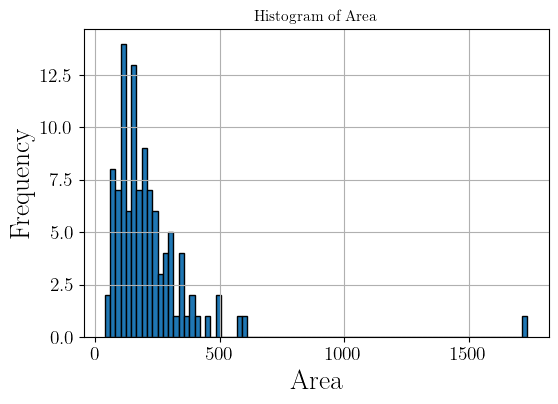

In [80]:
plt.figure(figsize=(6, 4))
plt.hist(X_df['area'], bins=80, edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Area')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

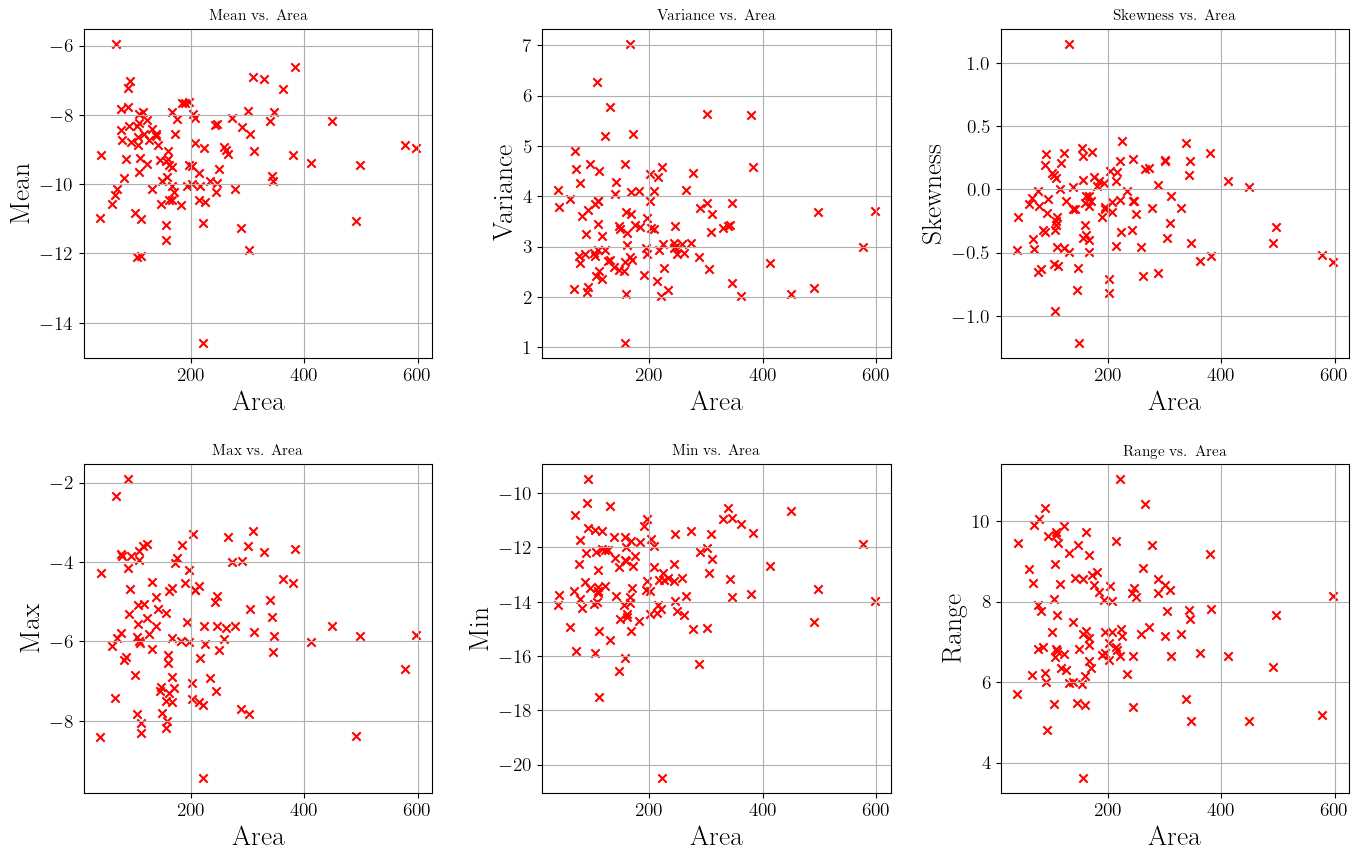

In [71]:
# Create subplots for each variable against area
fig, axs = plt.subplots(2, 3, figsize=(14, 9))

# List of variables to plot
variables = ['mean', 'variance', 'skewness', 'max', 'min', 'range']

gap_points = X_df[X_df['gap'] == 1]
random_points = X_df[X_df['gap'] == 0]

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot each variable against area
for i, variable in enumerate(variables):
    axs[i].scatter(gap_points['area'], gap_points[variable], color='red', marker='x')
    axs[i].set_xlabel('Area')
    axs[i].set_ylabel(variable.capitalize())
    axs[i].set_title(f'{variable.capitalize()} vs. Area')
    axs[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [72]:
def calculate_mean_variance_df(df):
    """
    Calculate the mean and variance for each column in the dataframe,
    and then compute the mean of these means and the mean of these variances.

    Parameters:
    df (pd.DataFrame): The input dataframe.

    Returns:
    tuple: Two lists containing the means and variances for each column.
    """
    means = []
    variances = []

    for column in df.columns:
        column_data = df[column].dropna().tolist()
        if len(column_data) > 1:  # Ensure there's enough data to calculate variance
            mean, variance = calculate_mean_variance(column_data)
            means.append(mean)
            variances.append(variance)

    average_mean = np.mean(means)
    average_variance = np.mean(variances)

    return average_mean, average_variance


In [83]:
def compare_methods_and_plot(series_dataframe, series_dataframe_random, name):
    
    # Calculate AVERAGE TIME SERIES THEN MEAN AND VARIANCE
    average_time_series_gap = series_dataframe.mean(axis=1, skipna=True)
    average_time_series_random = series_dataframe_random.mean(axis=1, skipna=True)

    ensemble_mean_gap, ensemble_variance_gap = calculate_mean_variance(average_time_series_gap.dropna().tolist())
    ensemble_mean_random, ensemble_variance_random = calculate_mean_variance(average_time_series_random.dropna().tolist())

    # Calculate MEANS AND VARIANCES, THEN FIND MEAN MEAN AND MEAN VARIANCE
    gap_means, gap_variances = calculate_mean_variance_df(series_dataframe)
    random_means, random_variances = calculate_mean_variance_df(series_dataframe_random)

    average_mean_gap = np.mean(gap_means)
    average_variance_gap = np.mean(gap_variances)
    average_mean_random = np.mean(random_means)
    average_variance_random = np.mean(random_variances)

    # All points to be plotted
    x_points = [ensemble_mean_gap, ensemble_mean_random, average_mean_gap, average_mean_random]
    y_points = [ensemble_variance_gap, ensemble_variance_random, average_variance_gap, average_variance_random]

    # Calculate dynamic limits with padding
    x_min, x_max = min(x_points), max(x_points)
    y_min, y_max = min(y_points), max(y_points)

    x_range = x_max - x_min
    y_range = y_max - y_min

    x_padding = x_range * 0.1  # 10% padding
    y_padding = y_range * 0.1  # 10% padding

    plt.figure(figsize=(7, 5))

    # AVERAGE TIME SERIES
    plt.scatter(ensemble_mean_gap, ensemble_variance_gap, color='red', marker='x', s=100, label='Gap Points Ensemble')
    plt.scatter(ensemble_mean_random, ensemble_variance_random, color='blue', marker='o', s=100, label='Random Points Ensemble')

    # MEAN MEAN AND MEAN VARIANCE
    plt.scatter(average_mean_gap, average_variance_gap, color='red', marker='x', label='Gap Points Aggregate')
    plt.scatter(average_mean_random, average_variance_random, color='blue', marker='o', label='Random Points Aggregate')

    plt.xlabel('Mean')
    plt.ylabel('Variance')
    plt.legend()
    plt.grid(True)

    # Apply the dynamic limits with padding
    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)

    plt.savefig(f'{name}.pdf')
    plt.show()

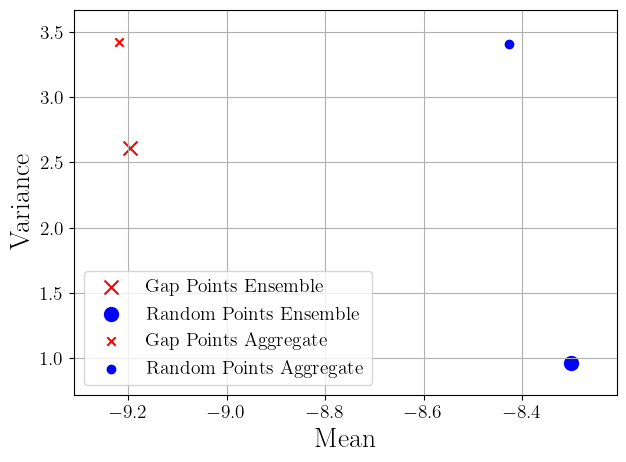

In [87]:
compare_methods_and_plot(series_dataframe_g1, series_dataframe_random_g1,'ensemble_ts2')

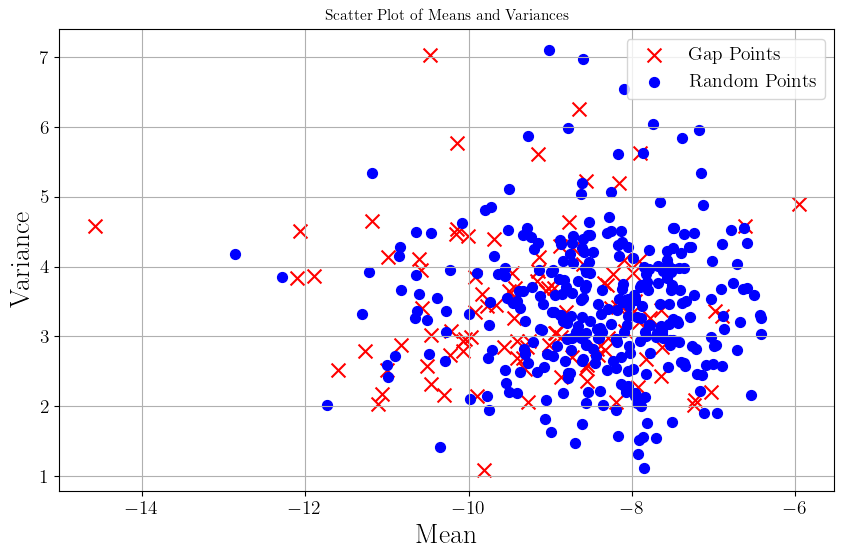

In [92]:
import matplotlib.pyplot as plt

def plot_scatter_filtered(df, x_col, y_col, title):
    """
    Plot a scatter plot using specified columns from the dataframe, with different colors and markers
    based on the 'name' column.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    x_col (str): The name of the column to use for the x-axis.
    y_col (str): The name of the column to use for the y-axis.
    title (str): The title of the plot.
    """
    gap_df = df[df['name'].str.match(r'gap\d+$')]
    random_df = df[df['name'].str.match(r'gap\d+_random\d+$')]

    plt.figure(figsize=(10, 6))
    
    # Plot gap points
    plt.scatter(gap_df[x_col], gap_df[y_col], color='red', marker='x', s=100, label='Gap Points')
    
    # Plot random points
    plt.scatter(random_df[x_col], random_df[y_col], color='blue', marker='o', s=50, label='Random Points')

    plt.xlabel(x_col.capitalize())
    plt.ylabel(y_col.capitalize())
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_scatter_filtered(X_df, 'mean', 'variance', 'Scatter Plot of Means and Variances')


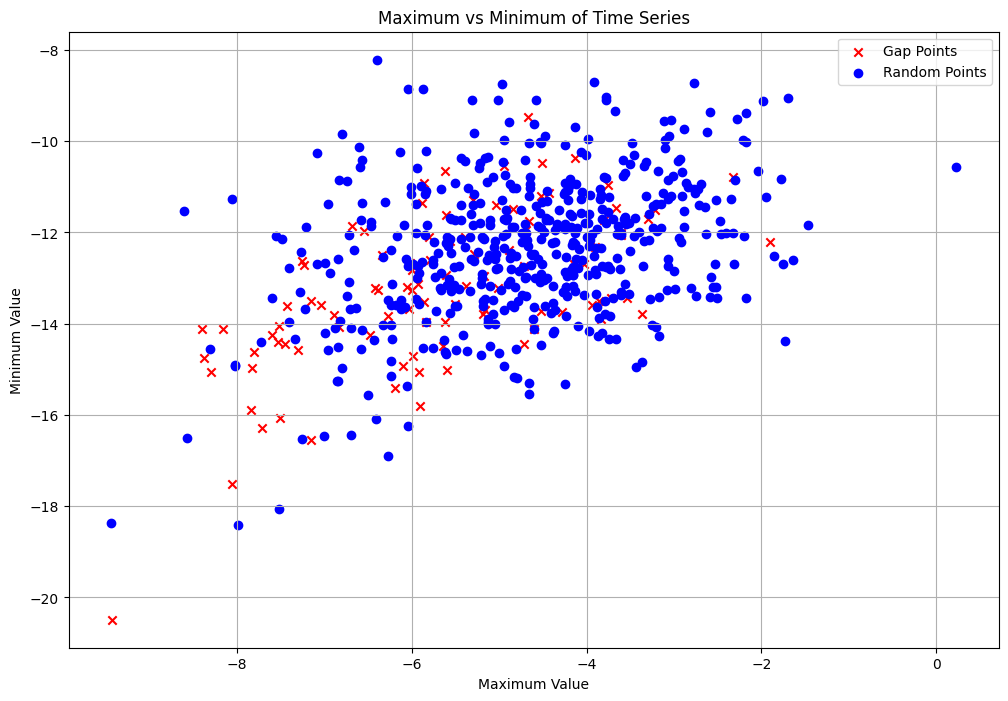

In [ ]:
import matplotlib.pyplot as plt

# Function to calculate the max and min of each column in a dataframe
def calculate_max_min_df(df):
    max_values = []
    min_values = []
    for column in df.columns:
        time_series = df[column].dropna().tolist()  # Drop NaN values
        max_value = max(time_series)
        min_value = min(time_series)
        max_values.append(max_value)
        min_values.append(min_value)
    return max_values, min_values

# Calculate max and min for the gap points
gap_max_values, gap_min_values = calculate_max_min_df(series_dataframe)

# Calculate max and min for the random points
random_max_values, random_min_values = calculate_max_min_df(series_dataframe_random)

# Plotting the scatter plot
plt.figure(figsize=(12, 8))

# Plot gap points as red crosses
plt.scatter(gap_max_values, gap_min_values, color='red', marker='x', label='Gap Points')

# Plot random points as blue dots
plt.scatter(random_max_values, random_min_values, color='blue', marker='o', label='Random Points')

plt.xlabel('Maximum Value')
plt.ylabel('Minimum Value')
plt.title('Maximum vs Minimum of Time Series')
plt.legend()
plt.grid(True)
plt.show()


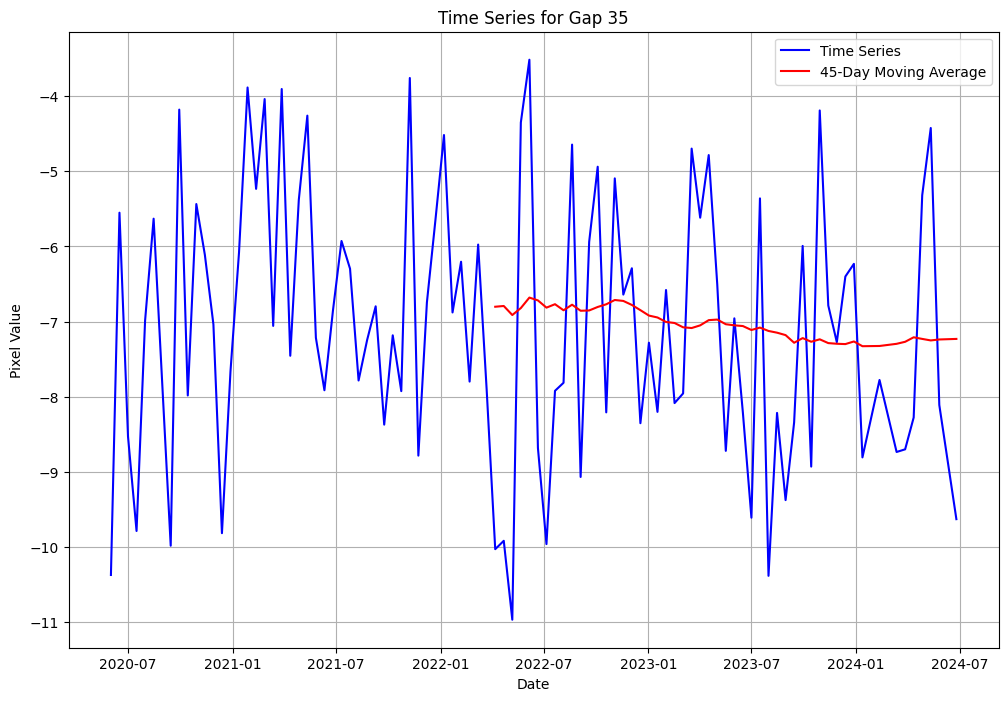

In [ ]:
import matplotlib.pyplot as plt

def plot_gap_time_series(df, gap_number, window_size=45):
    """
    Plot the time series for a given gap number including a moving average.

    Parameters:
    df (pd.DataFrame): DataFrame containing the time series data.
    gap_number (int): Gap number to plot the time series for.
    window_size (int): Window size for the moving average.
    """
    gap_col = f'gap{gap_number}'

    if gap_col in df.columns:
        time_series = df[gap_col].dropna()
        moving_average = time_series.rolling(window=window_size).mean()

        plt.figure(figsize=(12, 8))
        plt.plot(time_series.index, time_series, label='Time Series', color='blue')
        plt.plot(moving_average.index, moving_average, label=f'{window_size}-Day Moving Average', color='red')
        plt.title(f'Time Series for Gap {gap_number}')
        plt.xlabel('Date')
        plt.ylabel('Pixel Value')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"Gap {gap_number} not found in the DataFrame.")

# Example usage
gap_number = 35
plot_gap_time_series(series_dataframe, gap_number, window_size=45)


In [ ]:
df

,fid,event,last_alive,first_stan,last_stand,first_gap,notes,confirmed,centroid_x,centroid_y,area
0,22,standing&b/u,NaN,2016-06,2017-12,2018-06,NaN,checked,556651.360,9533727.893,105.412
1,23,standing&b/u,NaN,2016-06,2017-06,2017-12,NaN,checked,555897.816,9533599.821,156.257
2,46,standing&b/u,2016-06,2016-12,2023-04,2023-10,very few branches and mostly gap now,checked,561176.381,9523245.382,106.495
3,62,standing&b/u,2018-06,2018-12,2019-06,2020-06,NaN,checked,563785.032,9527067.637,207.746
4,66,b/u,2023-09,NaN,NaN,2023-10,NaN,checked,563329.777,9527728.359,265.294
...,...,...,...,...,...,...,...,...,...,...,...
102,936,?b/u,2022-10,NaN,NaN,2022-11,NaN,?,557663.011,9544779.686,41.274
103,938,b/u,2022-10,NaN,NaN,2022-11,NaN,checked,557568.600,9544912.789,122.074
104,954,standing&b/u,2019-06,2019-12,2020-06,2020-11,NaN,checked,558675.979,9548226.623,78.080
105,958,b/u,2022-03,NaN,NaN,2022-06,NaN,checked,559284.896,9548405.319,85.460


In [ ]:
# Convert the 'first_gap' column to datetime format if it's not already
df['first_gap'] = pd.to_datetime(df['first_gap'], errors='coerce')

# Sort the DataFrame by the 'first_gap' column with earlier dates at the top
df_sorted = df.sort_values(by='first_gap', ascending=True)

df_sorted

,fid,event,last_alive,first_stan,last_stand,first_gap,notes,confirmed,centroid_x,centroid_y,area
1,23,standing&b/u,NaN,2016-06,2017-06,2017-12-01,NaN,checked,555897.816,9533599.821,156.257
0,22,standing&b/u,NaN,2016-06,2017-12,2018-06-01,NaN,checked,556651.360,9533727.893,105.412
77,754,b/u,2018-06,NaN,NaN,2019-06-01,NaN,checked,509727.214,9872802.685,108.417
34,417,b/u,2018-06,NaN,NaN,2020-06-01,NaN,checked,558698.777,9521596.283,300.861
3,62,standing&b/u,2018-06,2018-12,2019-06,2020-06-01,NaN,checked,563785.032,9527067.637,207.746
...,...,...,...,...,...,...,...,...,...,...,...
40,505,standing&b/u,2022-12,2023-02,2023-09,2024-02-01,NaN,checked,561891.819,9512891.764,193.730
78,771,standing&b/u,2022-10,2022-12,2023-07,2024-02-01,NaN,checked,508787.929,9876333.354,89.455
37,433,standing&b/u,2021-11,2022-03,2023-06,2024-02-01,standing but mainly gap,checked,556023.536,9525024.306,38.999
61,686,standing&b/u,2021-11,2022-06,2023-09,2024-02-01,NaN,checked,562820.100,9516515.020,92.068


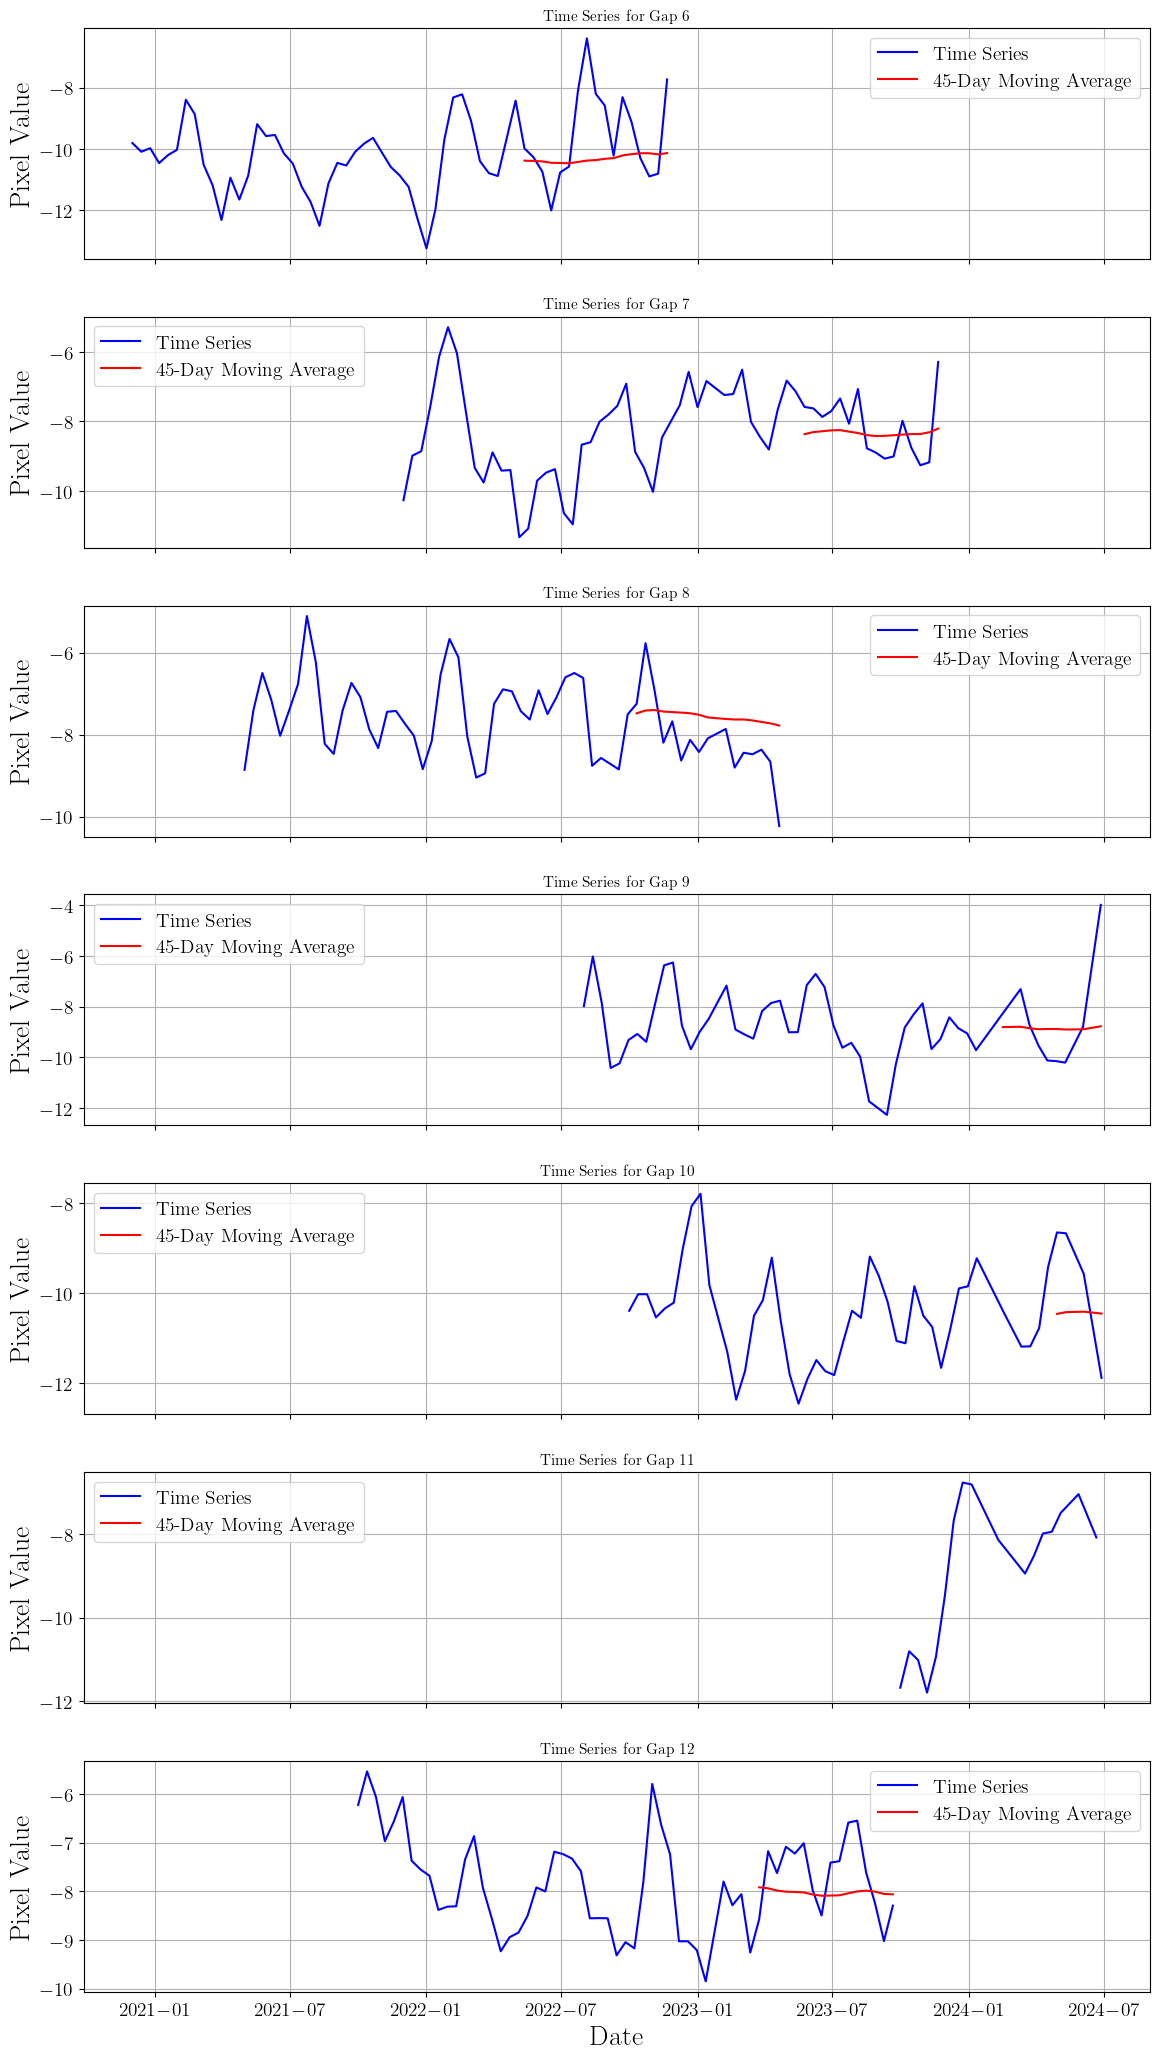

In [ ]:
import matplotlib.pyplot as plt

def plot_gap_time_series(df, gap_numbers, window_size=45):
    """
    Plot the time series for given gap numbers including a moving average.

    Parameters:
    df (pd.DataFrame): DataFrame containing the time series data.
    gap_numbers (list): List of gap numbers to plot the time series for.
    window_size (int): Window size for the moving average.
    """
    n_gaps = len(gap_numbers)
    fig, axes = plt.subplots(n_gaps, 1, figsize=(12, n_gaps * 3), sharex=True)

    for i, gap_number in enumerate(gap_numbers):
        gap_col = f'gap{gap_number}'
        
        if gap_col in df.columns:
            time_series = df[gap_col].dropna()
            moving_average = time_series.rolling(window=window_size).mean()
            
            axes[i].plot(time_series.index, time_series, label='Time Series', color='blue')
            axes[i].plot(moving_average.index, moving_average, label=f'{window_size}-Day Moving Average', color='red')
            axes[i].set_title(f'Time Series for Gap {gap_number}')
            axes[i].set_ylabel('Pixel Value')
            axes[i].legend()
            axes[i].grid(True)
        else:
            print(f"Gap {gap_number} not found in the DataFrame.")

    axes[-1].set_xlabel('Date')
    plt.tight_layout()
    plt.show()

# Sort the DataFrame by 'first_gap' column
df['first_gap'] = pd.to_datetime(df['first_gap'], errors='coerce')
df_sorted = df.sort_values(by='first_gap', ascending=True)

# Extract the top 10 gap numbers
top_10_gaps = (df_sorted.head(10).index + 1).tolist()

# Plot the top 10 gaps
plot_gap_time_series(series_dataframe_filtered, [6,7,8,9,10,11,12], window_size=45)


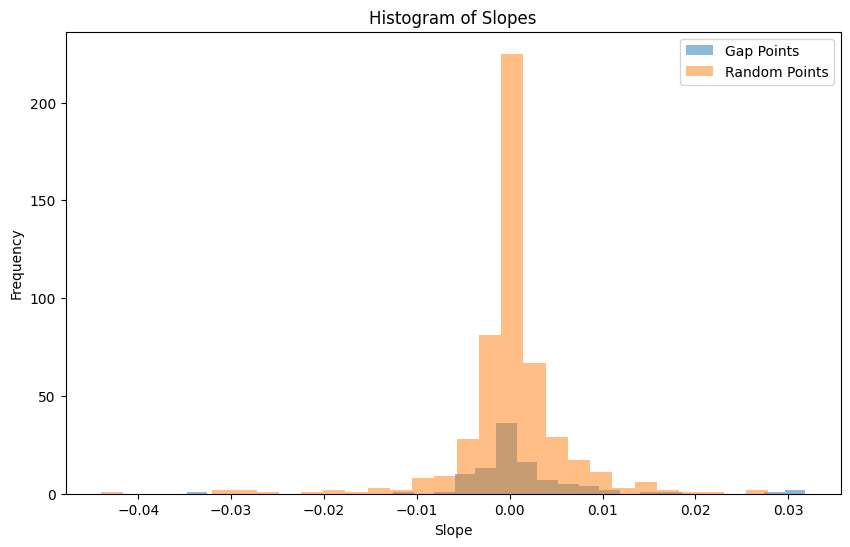

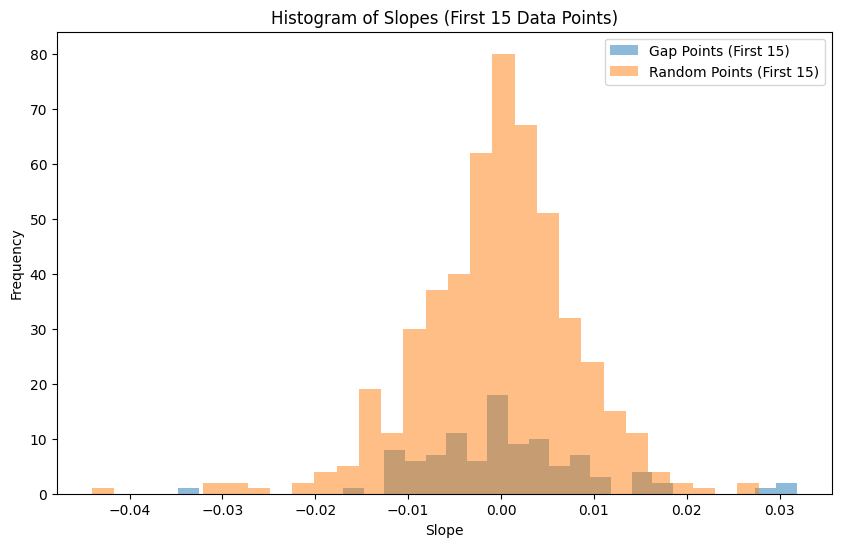

Slopes for all data points (Gap):
      Gap         Slope
83  gap79 -3.477506e-02
34  gap34  3.184848e-02
42  gap41  2.981229e-02
65  gap62  2.955788e-02
10  gap11  1.659535e-02
..    ...           ...
0    gap1 -9.411025e-05
96  gap95  7.417549e-05
39  gap39  5.319767e-05
72  gap69  2.511403e-05
62   gap6  5.154122e-07

[101 rows x 2 columns]
Average slope for all data points (Gap): 0.00123085780750155
Slopes for all data points (Random):
            Random         Slope
419  gap79_random5 -4.402943e-02
415  gap79_random1 -3.074538e-02
317  gap60_random3 -3.032404e-02
214  gap41_random5 -2.958099e-02
418  gap79_random4 -2.785182e-02
..             ...           ...
3     gap1_random4  1.992743e-05
59   gap12_random5 -1.069497e-05
97    gap2_random3 -1.055924e-05
331  gap63_random2 -8.971101e-06
234  gap45_random5  2.507822e-07

[505 rows x 2 columns]
Average slope for all data points (Random): 0.0001544435928333824
Slopes for first 15 data points (Gap):
       Gap     Slope
83   gap79

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Example DataFrame structures
# series_dataframe = pd.DataFrame(...) # Placeholder for your actual dataframe
# series_dataframe_random = pd.DataFrame(...) # Placeholder for your actual dataframe

# Function to calculate slope of time series
def calculate_slopes(df):
    slopes = {}
    for column in df.columns:
        series = df[column].dropna()
        if len(series) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(series.index.map(pd.Timestamp.toordinal), series.values)
            slopes[column] = slope
    return slopes

# Calculate slopes for all data points
slopes_gap = calculate_slopes(series_dataframe)
slopes_random = calculate_slopes(series_dataframe_random)

# Plot histogram of the slopes
plt.figure(figsize=(10, 6))
plt.hist(list(slopes_gap.values()), bins=30, alpha=0.5, label='Gap Points')
plt.hist(list(slopes_random.values()), bins=30, alpha=0.5, label='Random Points')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.title('Histogram of Slopes')
plt.legend()
plt.show()

# Function to calculate slope of the first 15 data points
def calculate_slopes_first_15(df):
    slopes = {}
    for column in df.columns:
        series = df[column].dropna()[:15]
        if len(series) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(series.index.map(pd.Timestamp.toordinal), series.values)
            slopes[column] = slope
    return slopes

# Calculate slopes for the first 15 data points
slopes_gap_first_15 = calculate_slopes_first_15(series_dataframe)
slopes_random_first_15 = calculate_slopes_first_15(series_dataframe_random)

# Plot histogram of the slopes for the first 15 data points
plt.figure(figsize=(10, 6))
plt.hist(list(slopes_gap_first_15.values()), bins=30, alpha=0.5, label='Gap Points (First 15)')
plt.hist(list(slopes_random_first_15.values()), bins=30, alpha=0.5, label='Random Points (First 15)')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.title('Histogram of Slopes (First 15 Data Points)')
plt.legend()
plt.show()

# Store slopes in dataframes for output
slopes_gap_df = pd.DataFrame(list(slopes_gap.items()), columns=['Gap', 'Slope'])
slopes_random_df = pd.DataFrame(list(slopes_random.items()), columns=['Random', 'Slope'])
slopes_gap_first_15_df = pd.DataFrame(list(slopes_gap_first_15.items()), columns=['Gap', 'Slope'])
slopes_random_first_15_df = pd.DataFrame(list(slopes_random_first_15.items()), columns=['Random', 'Slope'])

# Sort DataFrames by the magnitude of the slopes
slopes_gap_df['Abs_Slope'] = slopes_gap_df['Slope'].abs()
slopes_gap_df = slopes_gap_df.sort_values(by='Abs_Slope', ascending=False).drop(columns='Abs_Slope')

slopes_random_df['Abs_Slope'] = slopes_random_df['Slope'].abs()
slopes_random_df = slopes_random_df.sort_values(by='Abs_Slope', ascending=False).drop(columns='Abs_Slope')

slopes_gap_first_15_df['Abs_Slope'] = slopes_gap_first_15_df['Slope'].abs()
slopes_gap_first_15_df = slopes_gap_first_15_df.sort_values(by='Abs_Slope', ascending=False).drop(columns='Abs_Slope')

slopes_random_first_15_df['Abs_Slope'] = slopes_random_first_15_df['Slope'].abs()
slopes_random_first_15_df = slopes_random_first_15_df.sort_values(by='Abs_Slope', ascending=False).drop(columns='Abs_Slope')

# Calculate average slopes
avg_slope_gap = np.mean(list(slopes_gap.values()))
avg_slope_random = np.mean(list(slopes_random.values()))
avg_slope_gap_first_15 = np.mean(list(slopes_gap_first_15.values()))
avg_slope_random_first_15 = np.mean(list(slopes_random_first_15.values()))

# Display DataFrames and average slopes
print("Slopes for all data points (Gap):")
print(slopes_gap_df)
print(f"Average slope for all data points (Gap): {avg_slope_gap}")

print("Slopes for all data points (Random):")
print(slopes_random_df)
print(f"Average slope for all data points (Random): {avg_slope_random}")

print("Slopes for first 15 data points (Gap):")
print(slopes_gap_first_15_df)
print(f"Average slope for first 15 data points (Gap): {avg_slope_gap_first_15}")

print("Slopes for first 15 data points (Random):")
print(slopes_random_first_15_df)
print(f"Average slope for first 15 data points (Random): {avg_slope_random_first_15}")


In [ ]:
slopes_gap_df.iloc[:15]

,Gap,Slope
83,gap79,-0.034775
34,gap34,0.031848
42,gap41,0.029812
65,gap62,0.029558
10,gap11,0.016595
37,gap37,0.015380
17,gap18,-0.012077
75,gap71,0.011794
36,gap36,0.010989
44,gap43,0.009617


In [ ]:
slopes_gap_first_15_df.iloc[:15]

,Gap,Slope
83,gap79,-0.034775
34,gap34,0.031848
42,gap41,0.029812
65,gap62,0.029558
96,gap95,0.016808
10,gap11,0.016595
37,gap37,0.015380
13,gap14,-0.015197
92,gap91,0.015183
29,gap29,0.015050


In [ ]:
import pandas as pd

# Function to keep only the first 20 datapoints from each column
def keep_first_20_datapoints(df):
    new_df = pd.DataFrame()
    for column in df.columns:
        new_df[column] = df[column].dropna().head(20)
    return new_df

# Create new dataframes with only the first 20 datapoints
series_dataframe_first_20 = keep_first_20_datapoints(series_dataframe)
series_dataframe_random_first_20 = keep_first_20_datapoints(series_dataframe_random)


display(series_dataframe_first_20)

print("First 20 datapoints (Random):")
print(series_dataframe_random_first_20)


C:\Users\olive\AppData\Local\Temp\ipykernel_15000\686087715.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[column] = df[column].dropna().head(20)
C:\Users\olive\AppData\Local\Temp\ipykernel_15000\686087715.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[column] = df[column].dropna().head(20)
C:\Users\olive\AppData\Local\Temp\ipykernel_15000\686087715.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

,gap1,gap10,gap100,gap101,gap102,gap103,gap104,gap105,gap106,gap107,...,gap90,gap91,gap92,gap93,gap94,gap95,gap96,gap97,gap98,gap99
2018-06-01,-10.502120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-16,-9.297849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-01,-8.267758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-16,-10.420167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-31,-11.324973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-15,-10.635946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-30,-9.172081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-14,-12.478315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-29,-9.010873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-14,-8.446815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


First 20 datapoints (Random):
            gap1_random1  gap1_random2  gap1_random3  gap1_random4  \
2018-06-01    -10.119809     -7.627235     -7.207240     -5.710144   
2018-06-16    -10.628239     -8.796131     -3.596188     -8.929593   
2018-07-01     -8.451586    -11.104799     -4.803452     -9.952376   
2018-07-16     -8.358435     -8.714020     -8.986774     -8.649684   
2018-07-31     -6.881218     -9.765591     -5.377458    -10.633912   
2018-08-15     -8.064460    -12.145857     -7.692147     -9.364805   
2018-08-30     -7.370413     -9.820137     -6.454256     -8.697748   
2018-09-14     -7.601336     -9.952654     -4.467419     -9.193385   
2018-09-29     -9.131495     -9.205712     -9.158199    -10.506021   
2018-10-14     -5.350689     -7.449153     -7.834142     -8.906875   
2018-10-29     -8.231565     -7.507986    -10.270396    -10.681920   
2018-11-13     -8.638515     -5.736263     -6.161050    -10.619016   
2018-11-28     -7.469044    -11.141290    -11.700363    -11.

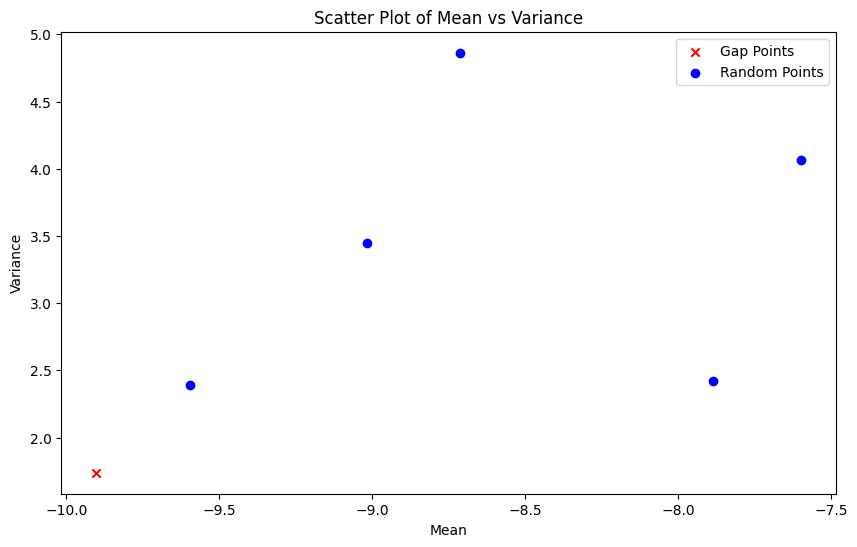

Mean and Variance (Gap Points):
            Mean  Variance
gap1   -9.901908  1.738237
gap10        NaN       NaN
gap100       NaN       NaN
gap101       NaN       NaN
gap102       NaN       NaN
...          ...       ...
gap95        NaN       NaN
gap96        NaN       NaN
gap97        NaN       NaN
gap98        NaN       NaN
gap99        NaN       NaN

[101 rows x 2 columns]
Mean and Variance (Random Points):
                   Mean  Variance
gap1_random1  -7.885674  2.419681
gap1_random2  -8.713502  4.863012
gap1_random3  -7.598551  4.063272
gap1_random4  -9.595696  2.391126
gap1_random5  -9.016691  3.447720
...                 ...       ...
gap99_random1       NaN       NaN
gap99_random2       NaN       NaN
gap99_random3       NaN       NaN
gap99_random4       NaN       NaN
gap99_random5       NaN       NaN

[505 rows x 2 columns]


In [ ]:
# Function to calculate mean and variance of each column
def calculate_mean_variance(df):
    mean_var = {'Mean': [], 'Variance': []}
    for column in df.columns:
        series = df[column].dropna()
        if len(series) > 0:
            mean_var['Mean'].append(series.mean())
            mean_var['Variance'].append(series.var())
        else:
            mean_var['Mean'].append(np.nan)
            mean_var['Variance'].append(np.nan)
    return pd.DataFrame(mean_var, index=df.columns)

# Calculate mean and variance for each column
mean_var_gap = calculate_mean_variance(series_dataframe_first_20)
mean_var_random = calculate_mean_variance(series_dataframe_random_first_20)

# Plot the mean and variance on a scatter plot
plt.figure(figsize=(10, 6))

# Gap points
plt.scatter(mean_var_gap['Mean'], mean_var_gap['Variance'], color='red', marker='x', label='Gap Points')

# Random points
plt.scatter(mean_var_random['Mean'], mean_var_random['Variance'], color='blue', marker='o', label='Random Points')

plt.xlabel('Mean')
plt.ylabel('Variance')
plt.title('Scatter Plot of Mean vs Variance')
plt.legend()
plt.show()

# Display the mean and variance dataframes
print("Mean and Variance (Gap Points):")
print(mean_var_gap)

print("Mean and Variance (Random Points):")
print(mean_var_random)

C:\Users\olive\AppData\Local\Temp\ipykernel_15000\3925283699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[column] = df[column].where(df.index.isin(series.index))
C:\Users\olive\AppData\Local\Temp\ipykernel_15000\3925283699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[column] = df[column].where(df.index.isin(series.index))
C:\Users\olive\AppData\Local\Temp\ipykernel_15000\3925283699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

First 20 datapoints (Gap):


C:\Users\olive\AppData\Local\Temp\ipykernel_15000\3925283699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[column] = df[column].where(df.index.isin(series.index))
C:\Users\olive\AppData\Local\Temp\ipykernel_15000\3925283699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[column] = df[column].where(df.index.isin(series.index))
C:\Users\olive\AppData\Local\Temp\ipykernel_15000\3925283699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

,gap1,gap10,gap100,gap101,gap102,gap103,gap104,gap105,gap106,gap107,...,gap90,gap91,gap92,gap93,gap94,gap95,gap96,gap97,gap98,gap99
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


First 20 datapoints (Random):


,gap1_random1,gap1_random2,gap1_random3,gap1_random4,gap1_random5,gap10_random1,gap10_random2,gap10_random3,gap10_random4,gap10_random5,...,gap98_random1,gap98_random2,gap98_random3,gap98_random4,gap98_random5,gap99_random1,gap99_random2,gap99_random3,gap99_random4,gap99_random5
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


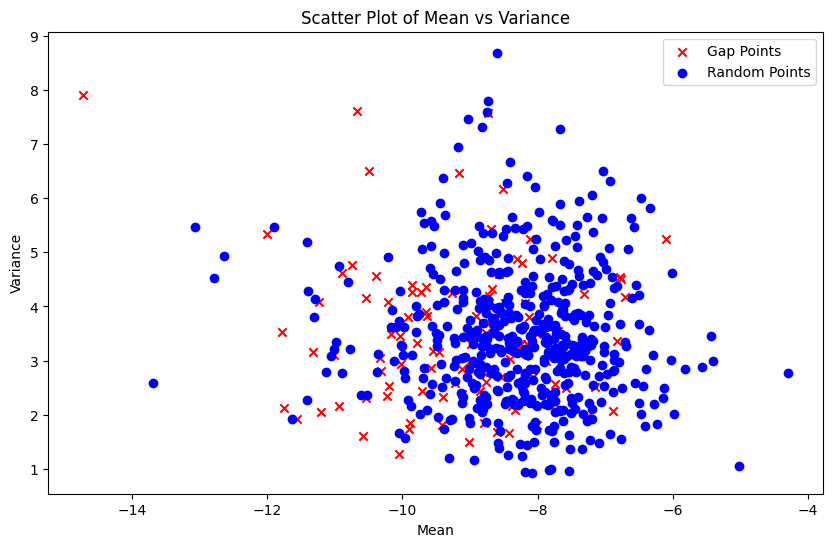

Mean and Variance (Gap Points):
             Mean  Variance
gap1    -9.901908  1.738237
gap10  -10.536655  2.306160
gap100 -10.197291  2.522433
gap101  -8.380619  2.168479
gap102  -9.780094  3.329557
...           ...       ...
gap95   -8.162896  3.298639
gap96   -8.715797  4.188184
gap97   -8.765015  2.603913
gap98   -7.786514  4.898181
gap99   -8.483320  4.071011

[101 rows x 2 columns]
Mean and Variance (Random Points):
                   Mean  Variance
gap1_random1  -7.885674  2.419681
gap1_random2  -8.713502  4.863012
gap1_random3  -7.598551  4.063272
gap1_random4  -9.595696  2.391126
gap1_random5  -9.016691  3.447720
...                 ...       ...
gap99_random1 -7.491194  2.214535
gap99_random2 -8.258280  3.597294
gap99_random3 -8.345765  2.192005
gap99_random4 -8.077893  1.787279
gap99_random5 -9.097399  4.079970

[505 rows x 2 columns]


In [ ]:
import pandas as pd

# Function to keep only the first 20 non-NaN datapoints from each column
def keep_first_20_non_nan_datapoints(df):
    new_df = pd.DataFrame(index=df.index)
    for column in df.columns:
        series = df[column].dropna().head(20)
        new_df[column] = df[column].where(df.index.isin(series.index))
    return new_df

# Create new dataframes with only the first 20 non-NaN datapoints
series_dataframe_first_20 = keep_first_20_non_nan_datapoints(series_dataframe)
series_dataframe_random_first_20 = keep_first_20_non_nan_datapoints(series_dataframe_random)

# Display the new dataframes
print("First 20 datapoints (Gap):")
display(series_dataframe_first_20)

print("First 20 datapoints (Random):")
display(series_dataframe_random_first_20)

# Function to calculate mean and variance of each column
def calculate_mean_variance(df):
    mean_var = {'Mean': [], 'Variance': []}
    for column in df.columns:
        series = df[column].dropna()
        if len(series) > 0:
            mean_var['Mean'].append(series.mean())
            mean_var['Variance'].append(series.var())
        else:
            mean_var['Mean'].append(np.nan)
            mean_var['Variance'].append(np.nan)
    return pd.DataFrame(mean_var, index=df.columns)

# Calculate mean and variance for each column
mean_var_gap = calculate_mean_variance(series_dataframe_first_20)
mean_var_random = calculate_mean_variance(series_dataframe_random_first_20)

# Plot the mean and variance on a scatter plot
plt.figure(figsize=(10, 6))

# Gap points
plt.scatter(mean_var_gap['Mean'], mean_var_gap['Variance'], color='red', marker='x', label='Gap Points')

# Random points
plt.scatter(mean_var_random['Mean'], mean_var_random['Variance'], color='blue', marker='o', label='Random Points')

plt.xlabel('Mean')
plt.ylabel('Variance')
plt.title('Scatter Plot of Mean vs Variance')
plt.legend()
plt.show()

# Display the mean and variance dataframes
print("Mean and Variance (Gap Points):")
print(mean_var_gap)

print("Mean and Variance (Random Points):")
print(mean_var_random)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the average time series
def calculate_average_time_series(df):
    return df.mean(axis=1)

# Calculate the average time series for each dataframe
average_time_series_gap = calculate_average_time_series(series_dataframe_first_20)
average_time_series_random = calculate_average_time_series(series_dataframe_random_first_20)

# Calculate the mean and variance of the average time series
mean_average_time_series_gap = average_time_series_gap.mean()
variance_average_time_series_gap = average_time_series_gap.var()
mean_average_time_series_random = average_time_series_random.mean()
variance_average_time_series_random = average_time_series_random.var()

# Function to calculate mean and variance of each column
def calculate_mean_variance(df):
    mean_var = {'Mean': [], 'Variance': []}
    for column in df.columns:
        series = df[column].dropna()
        if len(series) > 0:
            mean_var['Mean'].append(series.mean())
            mean_var['Variance'].append(series.var())
        else:
            mean_var['Mean'].append(np.nan)
            mean_var['Variance'].append(np.nan)
    return pd.DataFrame(mean_var, index=df.columns)

# Calculate mean and variance for each column
mean_var_gap = calculate_mean_variance(series_dataframe_first_20)
mean_var_random = calculate_mean_variance(series_dataframe_random_first_20)

# Calculate the mean of the means and the mean of the variances
mean_mean_gap = mean_var_gap['Mean'].mean()
mean_variance_gap = mean_var_gap['Variance'].mean()
mean_mean_random = mean_var_random['Mean'].mean()
mean_variance_random = mean_var_random['Variance'].mean()


# Plot the results
plt.figure(figsize=(10, 6))

# Highlight the mean and variance of the average time series
plt.scatter([mean_average_time_series_gap], [variance_average_time_series_gap], color='red', marker='D', s=100, label='Average Time Series (Gap Points)')
plt.scatter([mean_average_time_series_random], [variance_average_time_series_random], color='blue', marker='D', s=100, label='Average Time Series (Random Points)')

# Plot the mean of means and mean of variances
plt.scatter([mean_mean_gap], [mean_variance_gap], color='red', marker='x', s=100, label='Mean of Means and Variances (Gap Points)')
plt.scatter([mean_mean_random], [mean_variance_random], color='blue', marker='x', s=100, label='Mean of Means and Variances (Random Points)')

plt.xlabel('Mean')
plt.ylabel('Variance')
plt.title('Scatter Plot of Mean vs Variance')
plt.legend()
plt.show()


NameError: name 'series_dataframe_first_20' is not defined

In [ ]:
series_df=series_dataframe_filtered_scaled
series_random_df=series_dataframe_random_filtered_scaled

In [ ]:
def extract_features(df):
    features = []
    for column in df.columns:
        if df[column].dropna().empty:
            continue
        series = df[column].dropna()
        feature_dict = {
            'mean': series.mean(),
            'variance': series.var(),
            'max': series.max(),
            'min': series.min()
        }
        features.append(feature_dict)
    return pd.DataFrame(features)

# Extract features from both dataframes
gap_features = extract_features(series_df)
random_features = extract_features(series_random_df)

# Add labels
gap_features['label'] = 1
random_features['label'] = 0

# Combine the features into a single dataframe
combined_features = pd.concat([gap_features, random_features], ignore_index=True)

# Separate features and labels
X = combined_features.drop('label', axis=1)
y = combined_features['label']

# Ensure there are no NaNs in the dataset, without imputing
# Drop columns where all values are NaN
X = X.dropna(axis=1, how='all')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7073170731707317
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        85
           1       0.60      0.16      0.25        38

    accuracy                           0.71       123
   macro avg       0.66      0.56      0.53       123
weighted avg       0.68      0.71      0.64       123



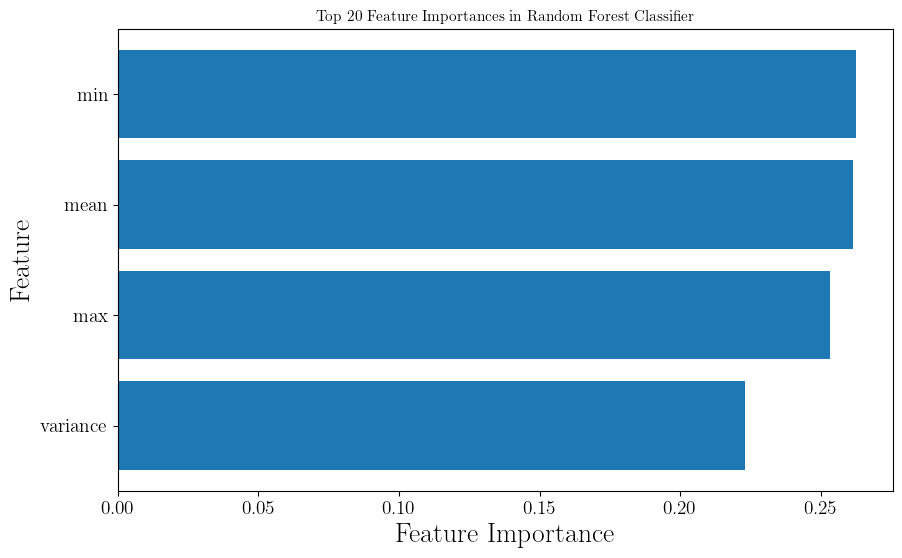

In [ ]:
feature_importances = clf.feature_importances_

# Create a dataframe to hold the feature names and their importance
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the dataframe by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'][:20], features_df['Importance'][:20])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances in Random Forest Classifier')
plt.gca().invert_yaxis()
plt.show()

Accuracy: 0.6585365853658537
              precision    recall  f1-score   support

           0       0.86      0.71      0.77        34
           1       0.23      0.43      0.30         7

    accuracy                           0.66        41
   macro avg       0.54      0.57      0.54        41
weighted avg       0.75      0.66      0.69        41



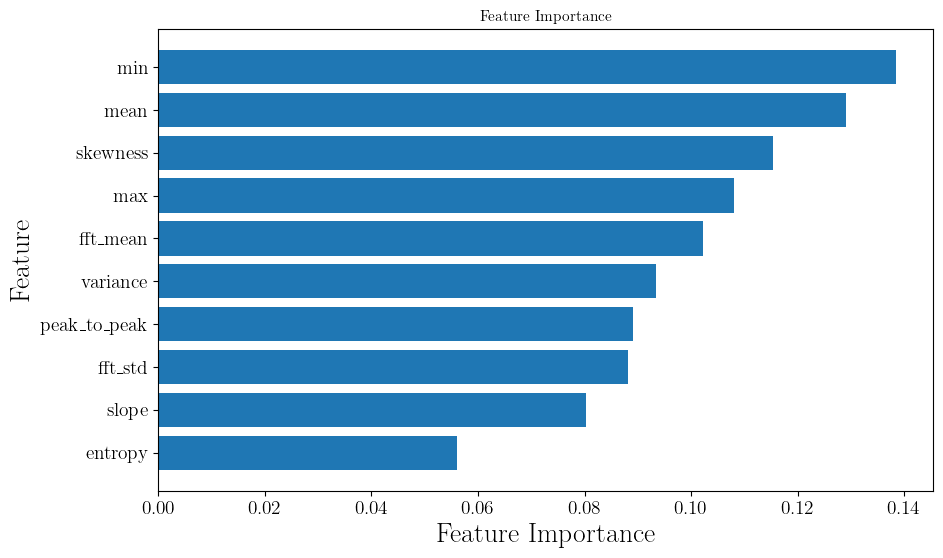

In [304]:
def hurst_exponent(ts):
    return nolds.hurst_rs(ts)

def lyapunov_exponent(ts):
    return nolds.lyap_r(ts, emb_dim=6)

def extract_advanced_features(df):
    features = []
    for column in df.columns:
        if df[column].dropna().empty:
            continue
        series = df[column].dropna()
        feature_dict = {
            'mean': series.mean(),
            'variance': series.var(),
            'max': series.max(),
            'min': series.min(),
            'skewness': skew(series),
            #'kurtosis': kurtosis(series),
            #'autocorrelation': series.autocorr(),
            'slope': np.polyfit(range(len(series)), series, 1)[0],
            'peak_to_peak': series.max() - series.min(),
            'peak_to_peak': series.max() - series.min(),
            'slope': np.polyfit(range(len(series)), series, 1)[0],
            'entropy': scipy_entropy(series.value_counts(normalize=True))
            #'zero_crossing_rate': ((series[:-1] * series[1:]) < 0).sum()
        }
        # Fourier transform features
        fft = np.fft.fft(series)
        fft = np.abs(fft[:len(fft) // 2])  # Take half as it's symmetric
        feature_dict['fft_mean'] = np.mean(fft)
        feature_dict['fft_std'] = np.std(fft)
        
        features.append(feature_dict)
    return pd.DataFrame(features)

# Extract advanced features from both dataframes
gap_features_advanced = extract_advanced_features(series_df)
random_features_advanced = extract_advanced_features(series_random_df)

# Add labels
gap_features_advanced['label'] = 1
random_features_advanced['label'] = 0

# Combine the features into a single dataframe
combined_features_advanced = pd.concat([gap_features_advanced, random_features_advanced], ignore_index=True)

# Separate features and labels
X_advanced = combined_features_advanced.drop('label', axis=1)
y_advanced = combined_features_advanced['label']

# Ensure there are no NaNs in the dataset, without imputing
# Drop columns where all values are NaN
X_advanced = X_advanced.dropna(axis=1, how='all')

# Split the data into training and testing sets
X_train_advanced, X_test_advanced, y_train_advanced, y_test_advanced = train_test_split(X_advanced, y_advanced, test_size=0.1, random_state=47)

# Train the Random Forest classifier
clf_advanced = RandomForestClassifier(n_estimators=200, random_state=40)
clf_advanced.fit(X_train_advanced, y_train_advanced)

# Make predictions
y_pred_advanced = clf_advanced.predict(X_test_advanced)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test_advanced, y_pred_advanced))
print(classification_report(y_test_advanced, y_pred_advanced))

# Plot feature importances
import matplotlib.pyplot as plt

feature_importances_advanced = clf_advanced.feature_importances_

features_df_advanced = pd.DataFrame({
    'Feature': X_advanced.columns,
    'Importance': feature_importances_advanced
})

features_df_advanced = features_df_advanced.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(features_df_advanced['Feature'][:20], features_df_advanced['Importance'][:20])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()